# Project: Neural Network - Fully Connected

## Pre read note:
1.Keras in Tensorflow 2.0 is used to build the fully connceted neural network(FCNN). 
2.For KNN, scikit learn pacakages are used to build KNN model. Since number of features are more PCA is leveraged for dimentionality reduction.
3.FCNN optimizer is taken as Adam and initialization is done using 'he normal'. Though multiple selections are possible , this is taken as starting point for the purpose of this notebook.
4.FCNN has many hyperparameters to tune for refining the results.Gridsearch was done for Learning rate and Drop Out rate. Since this was taking lot of time to calculate only the results are used in this notebook and the calculation part is taken out of this notebook.  One alternative was to use limited sample size (say 5000) to evaluate but the results were seen getting impacted with the sample size.

## 1.Import necessary libraries

In [1]:
# suppress warnings

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# load basic libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import h5py

# load libraries related to model building and evaluation

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,ReLU,Activation,Dropout,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
from tensorflow import random
from sklearn import metrics

In [2]:
# creating data frame to capture evaluation output of all FCNN models

resultsdf = pd.DataFrame(columns=['Hid.Layers','HL_Neurons','Wt.Init','BatchNorm','DropOut',\
                                  'DO_Val','Actv_fn','Actv_fn_Output','L2','Optimizer','LR',\
                                  'Loss_fn','Train.Loss','Test.Loss','Train.Acc','Test.Acc'])

## 2. Load Data

In [3]:
# The data file is given in h5 format and hence h5py package is used to read the data file

f = h5py.File('SVHN_single_grey1.h5', 'r')

In [4]:
# Identifying the various datasets given in the data file:

key_list = list(f.keys())
print('Datasets in the file:')
print (key_list,end='\n\n\n')

for key in key_list:
    dset = f[key]
    print(key,'dataset shape is',dset.shape)

Datasets in the file:
['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']


X_test dataset shape is (18000, 32, 32)
X_train dataset shape is (42000, 32, 32)
X_val dataset shape is (60000, 32, 32)
y_test dataset shape is (18000,)
y_train dataset shape is (42000,)
y_val dataset shape is (60000,)


1. There are 6 datasets given as specified above. 
2. Each image is of size 32*32 and there are 60000 images in total with train set containing 42000 and test set containing 18000 images respectively.

In [5]:
# variables are set

X_test =f['X_test']
y_test=f['y_test']
X_train=f['X_train']
y_train=f['y_train']
X_val=f['X_val']
y_val=f['y_val']

## 3. Analysis of the datasets

Train dataset images and corresponding labels:



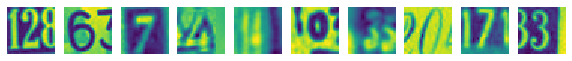

Label: [2 6 7 4 4 0 3 0 7 3]


In [6]:
print('Train dataset images and corresponding labels:',end='\n\n')
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()
print('Label: %s' % (y_train[0:10]))

Test dataset images and corresponding labels:



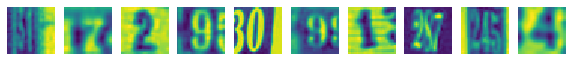

Label: [1 7 2 9 0 9 1 8 4 4]


In [7]:
print('Test dataset images and corresponding labels:',end='\n\n')
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
plt.show()
print('Label: %s' % (y_test[0:10]))

Validation dataset images and corresponding labels:



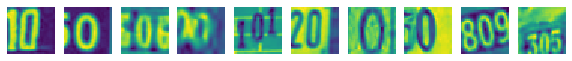

Label: [0 0 0 0 0 0 0 0 0 0]


In [8]:
print('Validation dataset images and corresponding labels:',end='\n\n')
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_val[i])
    plt.axis('off')
plt.show()
print('Label: %s' % (y_val[0:10]))

In [9]:
#Flatenning the train test and validation datasets - for use in KNN and FCNN models

X_train_flat = np.reshape(X_train, (42000, 1024))
X_test_flat = np.reshape(X_test, (18000, 1024))
X_val_flat = np.reshape(X_val, (60000, 1024))
y_val_flat = np.reshape(y_val, (60000, 1))

print(X_train_flat.shape)
print(X_test_flat.shape)
print(X_val_flat.shape)

(42000, 1024)
(18000, 1024)
(60000, 1024)


After flatenning each image is now represented in 1024 feature column

In [10]:
# check the distribution of data in validation data set to check the composition of image values

temp =pd.DataFrame(y_val_flat)
pd.value_counts(temp.values.flatten())

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

Data seems to be classified in a balanced way 

## 4. Model Building and Evaluation

### 4.1 KNN Model Building and Evaluation

In [11]:
# since the train and test data split is already provided we are using the same 
# applying standard scaler to scale the data

sc= StandardScaler()
X_train_flat= sc.fit_transform(X_train_flat)
X_test_flat = sc.transform(X_test_flat)


# since number of feature is 1024, we will deploy PCA for dimensionality reduction ( to get 95% coverage)

pca = PCA(.95)
X_train_flat = pca.fit_transform(X_train_flat)
X_test_flat = pca.transform(X_test_flat)
explained_variance = pca.explained_variance_ratio_
print("Number of features for .95 level is: %s" % pca.n_components_ ,end='\n\n\n')


print('eigen values ratio',end='\n\n')
print(pca.explained_variance_ratio_,end='\n\n\n')

Number of features for .95 level is: 50


eigen values ratio

[0.5598191  0.06486467 0.05280054 0.04113732 0.02081255 0.01758918
 0.0168549  0.01436677 0.01332983 0.01133389 0.01032099 0.00908578
 0.00725415 0.00669342 0.00596849 0.00573503 0.00532447 0.00523164
 0.00487154 0.00439073 0.00427882 0.00418913 0.00393288 0.00362117
 0.00342132 0.00327106 0.00313812 0.00306004 0.00295696 0.0028564
 0.0027092  0.00263664 0.00252298 0.0024492  0.0022927  0.00220866
 0.0021459  0.0020147  0.00199654 0.00189344 0.00182593 0.00179825
 0.00169521 0.00164529 0.00156011 0.00152204 0.00149051 0.0014427
 0.00138941 0.00135015]




#### Observation:
1. As observed above, 1st principal component contributes to 56% of coverage. 
2. However after this, each other principal component in contributing only marginally and it takes 49 more components to extend coverage from 56% to 95%.

In [12]:
#transform the validation dataset to PCA dimensions

P_reduce = np.array(pca.components_)
X_std_50D = np.dot(X_val_flat,P_reduce.T)
mydata_pca = pd.DataFrame(X_std_50D)

mydata_pca.head()

tind=len(mydata_pca.columns)
array=mydata_pca.values
X=array[:,0:tind]
y=y_val_flat[:,:]

#create train test split

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)


# gridsearch tuning for KNN

param_grid={'n_neighbors':(5,9,13,15,17,19,21,51,71)}
estimator=KNeighborsClassifier(weights='distance')
knn_t = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=3,n_jobs=4)
start_time=time.time() 
knn_t.fit(X_train, y_train.ravel())
#y_predict = knn_t.predict(X_test)
print('Best parameter for KNN is',knn_t.best_params_,end='\n\n')
print('Best estimator for KNN is',knn_t.best_estimator_,end='\n\n')
print('Best score for KNN is','%.4f' %(knn_t.best_score_),end='\n\n\n')
knn_t_means = knn_t.cv_results_['mean_test_score']
knn_t_stds = knn_t.cv_results_['std_test_score']
for mean,std,params in zip(knn_t_means,knn_t_stds,knn_t.cv_results_['params']):
    print("%0.3f(+/-%0.03f) for %r"%(mean,std*2,params))
et=round(time.time()-start_time,2)
print()
print('KNN hyperparameter tuning completed in',et, 'seconds',end='\n\n\n')

# build KNN with the best parameter derived as above

model = knn_t.best_estimator_
model.fit(X_train, y_train.ravel())
y_predict = model.predict(X_test)

# evaluate the KNN model built and print confusion matrix and classification report

accuracy_score = metrics.accuracy_score(y_test,y_predict)
matrix=metrics.confusion_matrix(y_test,y_predict)
print('Accuracy Score(KNN)=%.2f' %(accuracy_score),end='\n\n\n')
print('Confusion Matrix(KNN):')
print(matrix,end='\n\n\n')
print('Classification Report(KNN):')
print(metrics.classification_report(y_test, y_predict),end='\n\n\n')


Best parameter for KNN is {'n_neighbors': 21}

Best estimator for KNN is KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='distance')

Best score for KNN is 0.5222


0.485(+/-0.006) for {'n_neighbors': 5}
0.505(+/-0.005) for {'n_neighbors': 9}
0.515(+/-0.006) for {'n_neighbors': 13}
0.517(+/-0.007) for {'n_neighbors': 15}
0.519(+/-0.007) for {'n_neighbors': 17}
0.522(+/-0.005) for {'n_neighbors': 19}
0.522(+/-0.006) for {'n_neighbors': 21}
0.519(+/-0.004) for {'n_neighbors': 51}
0.516(+/-0.005) for {'n_neighbors': 71}

KNN hyperparameter tuning completed in 387.34 seconds


Accuracy Score(KNN)=0.54


Confusion Matrix(KNN):
[[1160   42   19   35   46   44  131   31  109  147]
 [  79 1281   56   96  113   41   38   72   35   36]
 [  78  142 1029   98   44   46   40  158   80   83]
 [  77  185  132  765   70  214   38   80  128  103]
 [  84  186   32   55 1217   

#### Observation:
1. With the k value set as 21 neighbours, the accuracy score of the KNN model is  poor @ 54% only.
2. While PCA was used to handle dimensionality reduction ( from 1024 features to 50 principal components), the model accuracy is still not coming out better.
3. This may be attibuted to the way principal components are scaterred ( only 1 principal component contributing significantly and 49 other principal components contributing marginally).
4. As seen in the classification report, recall values are also very poor with heavy spread - 41%-68%
5. Hence KNN is not appropriate method for image classification.

### 4.2 Fully Connected Neural Network Model Building and Evaluation

In [13]:
# dataset and variables reinitialized for use in FCNN model

X_test =f['X_test']
y_test=f['y_test']
X_train=f['X_train']
y_train=f['y_train']
X_val=f['X_val']
y_val=f['y_val']

# 32*32 image is flattened to 1024

X_train_flat = np.reshape(X_train, (42000, 1024))
X_test_flat = np.reshape(X_test, (18000, 1024))
X_val_flat = np.reshape(X_val, (60000, 1024))

# scaling is done on the flattened data

sc= StandardScaler()
X_train_flat= sc.fit_transform(X_train_flat)
X_test_flat = sc.transform(X_test_flat)

# labels are converted to one hot vector 

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [14]:
# function to create neural network model

def nn_model(input_dim,neurons,weight_init,batch_norm,drop_out,drop_val,actv,actv_out,optm_lr,loss_fn,mod_metrics,reg_l2):

    seed=9 
    np.random.seed(seed)
    random.set_seed(seed)
    
    model = Sequential()      
    # input and first layer   
    model.add(Dense(input_dim = input_dim,units=neurons[0],kernel_initializer=weight_init))
    if batch_norm== True:
        model.add(BatchNormalization())
    else:
        pass
    model.add(Activation(actv))
    if drop_out== True:    
        model.add(Dropout(drop_val))
    else:
        pass               
    # additional hidden layers
    for i in range(1,len(neurons)-1):   
        model.add(Dense(units=neurons[i], kernel_initializer=weight_init))
        if batch_norm== True:   
            model.add(BatchNormalization())
        else:
            pass        
        model.add(Activation(actv))   
        if drop_out== True:    
            model.add(Dropout(drop_val))
        else:
            pass    
    # output layer
    model.add(Dense(units=neurons[-1], kernel_initializer=weight_init,kernel_regularizer=regularizers.l2(reg_l2)))
    if batch_norm== True:   
        model.add(BatchNormalization())
    else:
        pass      
    model.add(Activation(actv_out)) 
 
    # compile the model
    model.compile(optimizer = optm_lr, loss = loss_fn, metrics = mod_metrics)
   
    return model

Following are the key highlights of the function above:
1. Function is seeded for model reprocibility.
2. Function is set to create the model layers and number of neurons dynamically based on input provided.
3. Weight initializion is also parameterized based on the input.
4. Batch normalization and Dropout layers are created dynamically based on input provided.
5. Loss function, Activation function etc. are all set based on the input parameters.
6. In the model execution parameters, given in all iterations below, Relu activation is used for intermediary layers and Softmax activation is used for output layer as this is case of multiclass classification.

In [15]:
# Initial execution of the model with 5 hidden layers and other key parameters as given below:

input_dim=1024
neurons=[500,400,300,200,100,10]
weight_init='he_normal'
batch_norm=False
drop_out=False
drop_val=0
actv='relu'
actv_out='softmax'
lr=0.001
optm_lr=Adam(learning_rate=lr)
loss_fn='categorical_crossentropy'
mod_metrics=['accuracy']
callback= False
cb_monitor='val_loss'
cb_mode='min'
cb_delta =.01
mc_monitor='val_accuracy'
mc_mode='max'
cb_patience=20
epochs=200
bs=1000
reg_l2=0
mfilename = 'NN_Model0.h5'


clear_session()
model = nn_model(input_dim,neurons,weight_init,batch_norm,drop_out,drop_val,actv,actv_out,optm_lr,loss_fn,mod_metrics,reg_l2)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               512500    
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               200400    
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               120300    
_________________________________________________________________
activation_2 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               6

In [16]:
# For the initial execution of the model, callback ( early stopping and model checkpointing) parameters are not set

start_time=time.time()

if callback== True:
    cb = EarlyStopping(monitor=cb_monitor, patience=cb_patience, mode=cb_mode,min_delta=cb_delta) 
    mc = ModelCheckpoint(mfilename, monitor=mc_monitor, mode=mc_mode, save_best_only=True,verbose=1)
    model.fit(X_train_flat, y_train,validation_data=(X_test_flat,y_test),epochs=epochs,batch_size=bs,verbose=2,callbacks=[cb,mc])
else:
    model.fit(X_train_flat, y_train,validation_data=(X_test_flat,y_test),epochs=epochs,batch_size=bs,verbose=0)

et=round(time.time()-start_time,2)
print()
print('NN Model0 fit completed in',et, 'seconds')


NN Model0 fit completed in 939.66 seconds


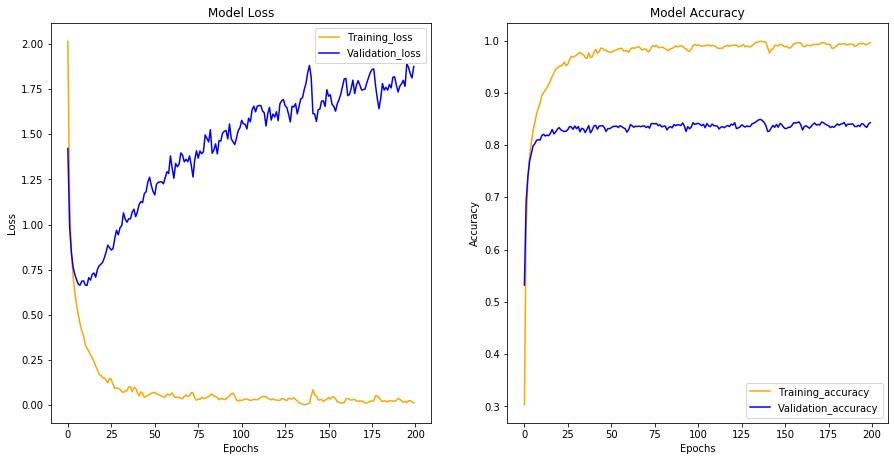

In [17]:
# For the initial execution of the model, the execution results are taken to plot in a graph to see the results visually

train_loss=val_loss=train_acc=val_acc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']

figure_obj = plt.figure(figsize = (15,25))
epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_acc, label='Training_accuracy', color = 'orange')
ax2.plot(epochs, val_acc, label='Validation_accuracy', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.title.set_text('Model Accuracy')

In [18]:
# For the initial execution of the model, calculate the loss and accuracy matrics based on the model fit done

if callback== True:
    best_model = load_model(mfilename)    
else:
    best_model = model

training_metrics = best_model.evaluate(X_train_flat, y_train, verbose=0)
test_metrics = best_model.evaluate(X_test_flat, y_test, verbose=0)
print('Training Accuracy: %.3f, Test Accuracy: %.3f' % (training_metrics[1], test_metrics[1]))
print('Training Loss: %.3f, Test Loss: %.3f' % (training_metrics[0], test_metrics[0]),end='\n\n\n')

# For the initial execution of the model, calculate the prediction(based on the model fit done) and calculate confusion matrix and classification report

y_predict = best_model.predict(X_test_flat)
y_pred = np.argmax(y_predict.T, axis=0)
y_tst = np.argmax(y_test.T, axis=0)
accuracy_score = metrics.accuracy_score(y_tst,y_pred)
matrix=metrics.confusion_matrix(y_tst,y_pred)
print('Accuracy Score :%0.3f' %(accuracy_score),end='\n\n')
print()
print('Confusion Matrix:')
print(matrix,end='\n\n\n')
print('Classification Report:')
print(metrics.classification_report(y_tst, y_pred),end='\n\n')

if drop_out== False:
    drop_val = None
else:
    pass

# capture the results in the results dataframe

curoutput = {'Hid.Layers':len(neurons)-1,
                  'HL_Neurons':neurons[:-1],
                  'Wt.Init':weight_init,
                  'BatchNorm':batch_norm,
                  'DropOut':drop_out,
                  'DO_Val':drop_val,
                  'Actv_fn':actv,
                  'Actv_fn_Output':actv_out,
                  'L2':reg_l2,
                  'Optimizer':optm_lr.__class__.__name__,
                  'LR':lr,
                  'Loss_fn':loss_fn,
                  'Train.Loss':'%.3f' %(training_metrics[0]),
                  'Test.Loss':'%.3f' %(test_metrics[0]),
                  'Train.Acc':'%.3f' %(training_metrics[1]),
                  'Test.Acc':'%.3f' %(test_metrics[1])}

resultsdf = resultsdf.append(curoutput,ignore_index=True)

resultsdf.iloc[[0]]

Training Accuracy: 0.998, Test Accuracy: 0.843
Training Loss: 0.006, Test Loss: 1.875


Accuracy Score :0.843


Confusion Matrix:
[[1566   32   10   26   23    8   46   18   21   64]
 [  25 1554   31   40   61   12   25   37   20   23]
 [  11   23 1567   45   22   15   12   43   16   49]
 [  11   31   42 1370   23   99   29   30   36   48]
 [  14   39   31   20 1587    7   46   15   22   31]
 [  14   20   15   73   11 1466   55    5   56   53]
 [  44   15   23   19   31   71 1531    9   65   24]
 [  19   59   42   21   17   16   13 1584    9   28]
 [  34   34   30   48   16   37   96    9 1447   61]
 [  45   37   35   43   25   39   17   16   43 1504]]


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1814
           1       0.84      0.85      0.85      1828
           2       0.86      0.87      0.86      1803
           3       0.80      0.80      0.80      1719
           4       0.87      0.88      0.87

,Hid.Layers,HL_Neurons,Wt.Init,BatchNorm,DropOut,DO_Val,Actv_fn,Actv_fn_Output,L2,Optimizer,LR,Loss_fn,Train.Loss,Test.Loss,Train.Acc,Test.Acc
0,5,"[500, 400, 300, 200, 100]",he_normal,False,False,None,relu,softmax,0,Adam,0.001,categorical_crossentropy,0.006,1.875,0.998,0.843


#### Observation:
1. Training accuracy has reached 99.8% but validation accuracy is only 84%. This clearly shows model is overfitting.
2. Since the model is capable of overfitting it can be inferred that the neuron/model infrastructure capacity is sufficient for the model.
3. As can be seen from the loss graph, after certain number of epoch, validation loss seems to be showing increasing trend while training loss moves towards 0.
4. Further the accuracy graph shows that after certain number of epoch, there is no significant improvement in validation accuracy while training accuracy seems to be reaching closer to 95+ range and hovers in that range for future epoch before reaching 99.8.
5. This shows that model need not execute full epoch ( from efficiency and optimization perspective) as beyond a certain point there is no significant improvement.
6. Hence callback can be leveraged to run the model only for certain epoch based on call back monitoring parameter.
7. Hence for the next model run, call back is set along with modelcheckpoint setting, inaddition to setting batch normalization on.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               512500    
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               200400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               1

,Hid.Layers,HL_Neurons,Wt.Init,BatchNorm,DropOut,DO_Val,Actv_fn,Actv_fn_Output,L2,Optimizer,LR,Loss_fn,Train.Loss,Test.Loss,Train.Acc,Test.Acc
1,5,"[500, 400, 300, 200, 100]",he_normal,True,False,None,relu,softmax,0,Adam,0.001,categorical_crossentropy,0.055,0.565,0.994,0.844


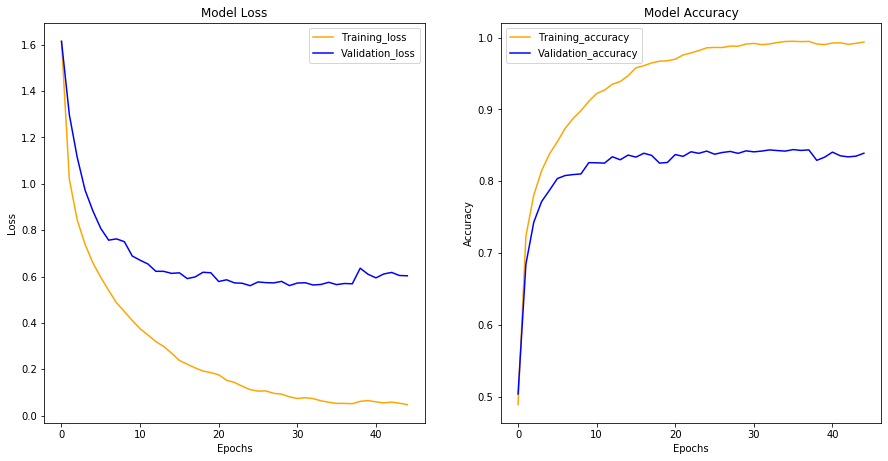

In [19]:
# For next model iteration, all the parameters are kept same as above but only batch normalization is turned on. 
# Futher callback is also turned on and is set to monitor validation loss and if there is no change of atleast .01 for 20 successive epoch it is set to stop.
# Also, model checkpoint is turned on to save the best model ( based on validation accuracy).
# model is given the name NN_Model1 and the model is saved as .h5 file with the same name.

clear_session()
input_dim=1024
neurons=[500,400,300,200,100,10]
weight_init='he_normal'
actv='relu'
actv_out='softmax'
lr=0.001
optm_lr=Adam(learning_rate=lr)
loss_fn='categorical_crossentropy'
mod_metrics=['accuracy']
bs=1000
callback= True
cb_monitor='val_loss'
cb_mode='min'
cb_delta =.01
mc_monitor='val_accuracy'
mc_mode='max'
cb_patience=20
epochs=200
batch_norm=True
drop_out=False
drop_val=0
reg_l2=0

mfilename = 'NN_Model1.h5'

start_time=time.time()      
model = nn_model(input_dim,neurons,weight_init,batch_norm,drop_out,drop_val,actv,actv_out,optm_lr,loss_fn,mod_metrics,reg_l2)
model.summary()



if callback== True:
    cb = EarlyStopping(monitor=cb_monitor, patience=cb_patience, mode=cb_mode,min_delta=cb_delta) 
    mc = ModelCheckpoint(mfilename, monitor=mc_monitor, mode=mc_mode, save_best_only=True,verbose=1)
    model.fit(X_train_flat, y_train,validation_data=(X_test_flat,y_test),epochs=epochs,batch_size=bs,verbose=0,callbacks=[cb,mc])
else:
    model.fit(X_train_flat, y_train,validation_data=(X_test_flat,y_test),epochs=epochs,batch_size=bs,verbose=0)

# the execution results are taken to plot in a graph to see the results visually
    
train_loss=val_loss=train_acc=val_acc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']


figure_obj = plt.figure(figsize = (15,25))
epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_acc, label='Training_accuracy', color = 'orange')
ax2.plot(epochs, val_acc, label='Validation_accuracy', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.title.set_text('Model Accuracy')   


#calculate the loss and accuracy matrics based on the best model fit done

if callback== True:
    best_model = load_model(mfilename)    
else:
    best_model = model

training_metrics = best_model.evaluate(X_train_flat, y_train, verbose=0)
test_metrics = best_model.evaluate(X_test_flat, y_test, verbose=0)
print('Training Accuracy: %.3f, Test Accuracy: %.3f' % (training_metrics[1], test_metrics[1]))
print('Training Loss: %.3f, Test Loss: %.3f' % (training_metrics[0], test_metrics[0]),end='\n\n\n')

et=round(time.time()-start_time,2)
print('NN Model1 execution  completed in',et, 'seconds',end='\n\n\n')     

if drop_out== False:
    drop_val = None
else:
    pass

# capture the results in the results dataframe

curoutput = {'Hid.Layers':len(neurons)-1,
                  'HL_Neurons':neurons[:-1],
                  'Wt.Init':weight_init,
                  'BatchNorm':batch_norm,
                  'DropOut':drop_out,
                  'DO_Val':drop_val,
                  'Actv_fn':actv,
                  'Actv_fn_Output':actv_out,
                  'L2':reg_l2,             
                  'Optimizer':optm_lr.__class__.__name__,
                  'LR':lr,
                  'Loss_fn':loss_fn,
                  'Train.Loss':'%.3f' %(training_metrics[0]),
                  'Test.Loss':'%.3f' %(test_metrics[0]),
                  'Train.Acc':'%.3f' %(training_metrics[1]),
                  'Test.Acc':'%.3f' %(test_metrics[1])}

resultsdf = resultsdf.append(curoutput,ignore_index=True)
resultsdf.iloc[[1]]

#### Observation:
1. As seen above, the model execution stops at epoch #45 as there is no significant improvement to the metrics (as set up in the parameters).
2. However the best model parameters are achieved at epoch #36 and that is the model that is saved ( modelcheckpoint parameter).
3. Though batch normalization is set, there is no significant impact to overfitting.
4. The training accuracy is at 99.4% and testing accuracy is 84.4% which still shows that model is still heavily overfitted.
5. Hence for the next iteration we use other regularization parameters (drop out and L2 regularization) and check the impact on model.
6. Callback and modelcheck point parameters are retained as given in this iteration.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               512500    
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               200400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0

,Hid.Layers,HL_Neurons,Wt.Init,BatchNorm,DropOut,DO_Val,Actv_fn,Actv_fn_Output,L2,Optimizer,LR,Loss_fn,Train.Loss,Test.Loss,Train.Acc,Test.Acc
2,5,"[500, 400, 300, 200, 100]",he_normal,True,True,0.3,relu,softmax,0.01,Adam,0.001,categorical_crossentropy,0.141,0.421,0.964,0.880


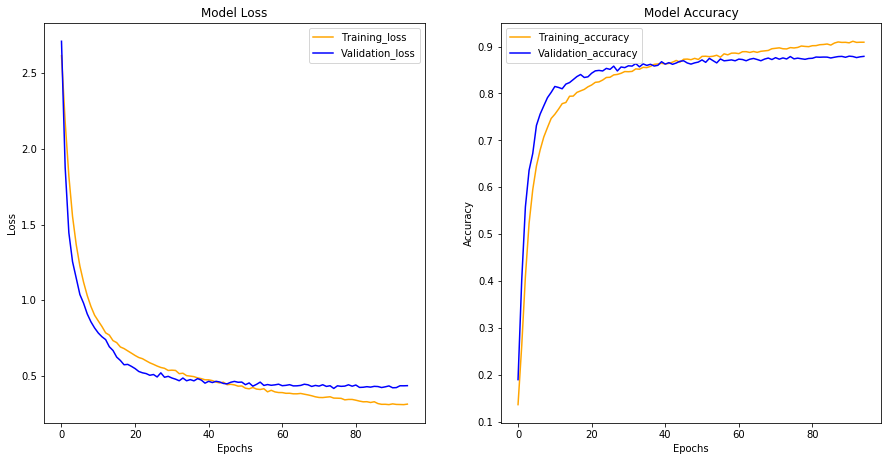

In [20]:
# For next model iteration, all the parameters are kept same as above, but regularization parameters are set (Dropout, L2, inaddition to batch normalization). 
# Futher callback is also turned on and is set to monitor validation loss and if there is no change of atleast .01 for 20 successive epoch it is set to stop.
# Also, model checkpoint is turned on to save the best model ( based on validation accuracy).
# model is given the name NN_Model2 and the model is saved as .h5 file with the same name.

clear_session()
input_dim=1024
neurons=[500,400,300,200,100,10]
weight_init='he_normal'
actv='relu'
actv_out='softmax'
lr=0.001
optm_lr=Adam(learning_rate=lr,amsgrad=True)
loss_fn='categorical_crossentropy'
mod_metrics=['accuracy']
bs=1000
callback= True
cb_monitor='val_loss'
cb_mode='min'
cb_delta =.01
mc_monitor='val_accuracy'
mc_mode='max'
cb_patience=20
epochs=200
batch_norm=True
drop_out=True
drop_val=0.3
reg_l2=0.01
   
mfilename = 'NN_Model2.h5'

start_time=time.time()      
model = nn_model(input_dim,neurons,weight_init,batch_norm,drop_out,drop_val,actv,actv_out,optm_lr,loss_fn,mod_metrics,reg_l2)
model.summary()

if callback== True:
    cb = EarlyStopping(monitor=cb_monitor, patience=cb_patience, mode=cb_mode,min_delta=cb_delta) 
    mc = ModelCheckpoint(mfilename, monitor=mc_monitor, mode=mc_mode, save_best_only=True,verbose=1)
    model.fit(X_train_flat, y_train,validation_data=(X_test_flat,y_test),epochs=epochs,batch_size=bs,verbose=2,callbacks=[cb,mc])
else:
    model.fit(X_train_flat, y_train,validation_data=(X_test_flat,y_test),epochs=epochs,batch_size=bs,verbose=0)


# the execution results are taken to plot in a graph to see the results visually
    
train_loss=val_loss=train_acc=val_acc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']

  
figure_obj = plt.figure(figsize = (15,25))
epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss')


ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_acc, label='Training_accuracy', color = 'orange')
ax2.plot(epochs, val_acc, label='Validation_accuracy', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.title.set_text('Model Accuracy')    

if callback== True:
    best_model = load_model(mfilename)    
else:
    best_model = model
    
#calculate the loss and accuracy matrics based on the best model fit done    

training_metrics = best_model.evaluate(X_train_flat, y_train, verbose=0)
test_metrics = best_model.evaluate(X_test_flat, y_test, verbose=0)
print('Training Accuracy: %.3f, Test Accuracy: %.3f' % (training_metrics[1], test_metrics[1]))
print('Training Loss: %.3f, Test Loss: %.3f' % (training_metrics[0], test_metrics[0]),end='\n\n\n')

et=round(time.time()-start_time,2)
print('NN Model2 execution completed in',et, 'seconds',end='\n\n\n')     

if drop_out== False:
    drop_val = None
else:
    pass

# capture the results in the results dataframe

curoutput = {'Hid.Layers':len(neurons)-1,
                  'HL_Neurons':neurons[:-1],
                  'Wt.Init':weight_init,
                  'BatchNorm':batch_norm,
                  'DropOut':drop_out,
                  'DO_Val':drop_val,
                  'Actv_fn':actv,
                  'Actv_fn_Output':actv_out,
                  'L2':reg_l2,             
                  'Optimizer':optm_lr.__class__.__name__,
                  'LR':lr,
                  'Loss_fn':loss_fn,
                  'Train.Loss':'%.3f' %(training_metrics[0]),
                  'Test.Loss':'%.3f' %(test_metrics[0]),
                  'Train.Acc':'%.3f' %(training_metrics[1]),
                  'Test.Acc':'%.3f' %(test_metrics[1])}

resultsdf = resultsdf.append(curoutput,ignore_index=True)
resultsdf.iloc[[2]]

#### Observation:
1. The graphs above show visually show the improvement in the model with the revised set of parameters. We can observe the smoothening of the loss and accuracy curves (when compared to initial model iteration).
2. The test accuracy has improved to 88% while training accuracy is down to 96.4%. This shows that the regularization is working to make the model more optimal.
3. Further, it has taken 95 epoch for the model to reach this point (inline with the call back parameters set)
4. The best model saved is obtained at epoch #91.
5. For this best fit model, confusion matrix and classification reports are printed below.

In [21]:

# based on the best model fit done, evaluate results, predit lables and calculate confusion matrix and classification report


training_metrics = best_model.evaluate(X_train_flat, y_train, verbose=0)
test_metrics = best_model.evaluate(X_test_flat, y_test, verbose=0)
print('Training Accuracy: %.3f, Test Accuracy: %.3f' % (training_metrics[1], test_metrics[1]))
print('Training Loss: %.3f, Test Loss: %.3f' % (training_metrics[0], test_metrics[0]),end='\n\n\n')

# predict based on the best model fit done

y_predict = best_model.predict(X_test_flat)
y_pred = np.argmax(y_predict.T, axis=0)
y_tst = np.argmax(y_test.T, axis=0)

# print scores , confusion matrix and classification report for the best fit model

accuracy_score = metrics.accuracy_score(y_tst,y_pred)
matrix=metrics.confusion_matrix(y_tst,y_pred)
print('Accuracy Score :%0.3f' %(accuracy_score),end='\n\n')
print()
print('Confusion Matrix:')
print(matrix,end='\n\n\n')
print('Classification Report:')
print(metrics.classification_report(y_tst, y_pred),end='\n\n')

Training Accuracy: 0.964, Test Accuracy: 0.880
Training Loss: 0.141, Test Loss: 0.421


Accuracy Score :0.880


Confusion Matrix:
[[1629   26    9   28   15    5   16   25   27   34]
 [   9 1628   19   24   46   10    9   48   25   10]
 [   8   20 1608   28   21   17    5   48   25   23]
 [   7   17   31 1459   14   89   14   29   41   18]
 [  10   45   14   20 1652   10   19    9   16   17]
 [   5   12   11   76    7 1532   45    6   47   27]
 [  29   13   11   18   29   82 1552   13   77    8]
 [  12   51   14   18   16    8    7 1663   10    9]
 [  17   32   19   44   16   29   58    6 1552   39]
 [  28   15   16   44   21   49   10   19   45 1557]]


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1814
           1       0.88      0.89      0.88      1828
           2       0.92      0.89      0.90      1803
           3       0.83      0.85      0.84      1719
           4       0.90      0.91      0.91

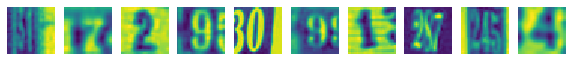

Actual Label for each of the above image in Test dataset: [1 7 2 9 0 9 1 8 4 4]
Predicted Label for each of the above image in Test dataset: [1 7 2 9 0 9 1 8 1 4]


In [22]:
# compare the predictions with actual label values for the test dataset

plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
plt.show()
print('Actual Label for each of the above image in Test dataset: %s' % (y_tst[0:10]))
print('Predicted Label for each of the above image in Test dataset: %s' % (y_pred[0:10]))

#### Observation:
1. Out of the 10 test images , the model has predicted the classification of 9 images correctly.

## 5. Evaluation and Conclusion

In [23]:
resultsdf

,Hid.Layers,HL_Neurons,Wt.Init,BatchNorm,DropOut,DO_Val,Actv_fn,Actv_fn_Output,L2,Optimizer,LR,Loss_fn,Train.Loss,Test.Loss,Train.Acc,Test.Acc
0,5,"[500, 400, 300, 200, 100]",he_normal,False,False,None,relu,softmax,0,Adam,0.001,categorical_crossentropy,0.006,1.875,0.998,0.843
1,5,"[500, 400, 300, 200, 100]",he_normal,True,False,None,relu,softmax,0,Adam,0.001,categorical_crossentropy,0.055,0.565,0.994,0.844
2,5,"[500, 400, 300, 200, 100]",he_normal,True,True,0.3,relu,softmax,0.01,Adam,0.001,categorical_crossentropy,0.141,0.421,0.964,0.880


#### Inference:
1. KNN , as a model for image classification, is not appropriate. As the image dimensions increase, the number of feature column increases phenominally and even with PCA ( as a tradeoff to handle curse of dimensionality), KNN struggles to give a decent prediction. Without PCA it may not even be practically possible to execute KNN model  and as the sample size increases it will take present enormous computational challenge.
2. Also KNN goes by distance approach to classification while FCNN models take the approach of breaking down the image (logically) in to individual feature identification (like strokes, curves, edges etc.)
3. Deep learning models need lot of data to train the network to make it more accurately predictable while its not the case with traditional ML models like KNN.
4. Image classification can be handled better using Deep learning approaches, esp convolution based. However fully connected neural networks also can give good results ( though not as close to convolution based neural networks).
5. FCNN model ( best fit model of iteration 3) gives a better class level Recall values as well - 85% to 91% (inaddition to overall accuracy).On an average roughly 9/10 images are predicted correct and this can also be verified with the sample evaluation done with 10 images. 
6. Out of the 10 images printed to compare the prediction against actual labels, 9 out of 10 images are predicted correct.The image that was not correctly predicted is '4' and as seen in the classification report and confusion matrix, in 45/1812 cases actual image of 4 is precited as 1.These may be the cases where the image is narrow/squeezed for the image of 4 that the model tends to give higher probability as 1 instead of 4.
7. As seen in the above table, fully connected neural network give 88% test accuracy (96.4% training accuracy) with certain level of regularization parameters.
8. There may be potential to tune this further however the above explains the principle behind this for the purpose of this project.
9. Data augmentation can also be applied as another stragey for regularization but it is not used for the purpose of this project.
10. Convolution neural networks can given even better accuracy results. 